# Decision tree model

In [52]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

import pickle


In [53]:
# Import dataframe
df0 = pickle.load(open('../../Data/Processed/regression_data.p','rb'))
df0.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [54]:
# Remove non desired data from model (Non predictor data or ethics concern)
df1 = df0.drop(['customer_id','gender'], axis=1)

In [55]:
# Shuffle data
df2 = shuffle(df1, random_state=42)

In [56]:
# Deal with missing values
df2.isna().sum()

distance_from_store       2
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64

In [57]:
# Low value count for missing data so we drop
df3 = df2.dropna()

In [58]:
df3.head()

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,0.67,0.297,1904.55,376,36,3,52.904167


In [59]:
# Split into input 'X' and output 'y'
X = df3.drop(['customer_loyalty_score'], axis = 1)
y = df3['customer_loyalty_score']

In [60]:
# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
                                                    )

In [61]:
# feature selection with regressive feature elemination
tree = DecisionTreeRegressor()

In [62]:
# fit model
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [63]:
# Assess accuracy and R2
y_pred = tree.predict(X_test) # Create predictions for tests
r_squared = r2_score(y_test,y_pred) # Compare prediction results to actual result
r_squared

0.8796028679723586

In [64]:
# Cross - validation
cv = KFold(n_splits = 4, shuffle=True, random_state = 42)
cv_scores = cross_val_score(tree, X_train, y_train, cv = cv, scoring='r2')
print(f'Cross-validation score : {round(cv_scores.mean(),2)}')

Cross-validation score : 0.85


In [65]:
# Calculate adjusted R2
num_data_points, num_input_vars = X_test.shape

adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R2 score : {round(adjusted_r_squared,2)}')

Adjusted R2 score : 0.87


In [66]:
# Check for overfitting
y_pred_training = tree.predict(X_train) # Create predictions for tests
r_squared = r2_score(y_train,y_pred_training) # Compare prediction results to actual result
r_squared

1.0

The model is perfectly predicting the training data, we might want to avoid this overfitting by adding some limitations to the model

In [67]:
# Finding the max_depth
max_depth_list = list(range(1,9))
accuracy_scores = []

for depth in max_depth_list:
    model = DecisionTreeRegressor(max_depth=depth,
                                  random_state=42
                                  )
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = r2_score(y_test,y_pred)
    accuracy_scores.append(accuracy)

accuracy_scores

[0.5279788857678871,
 0.7761238202289338,
 0.8472592872422113,
 0.8786690493044959,
 0.8663542483975902,
 0.8902198336495488,
 0.8934152024365236,
 0.872204147557132]

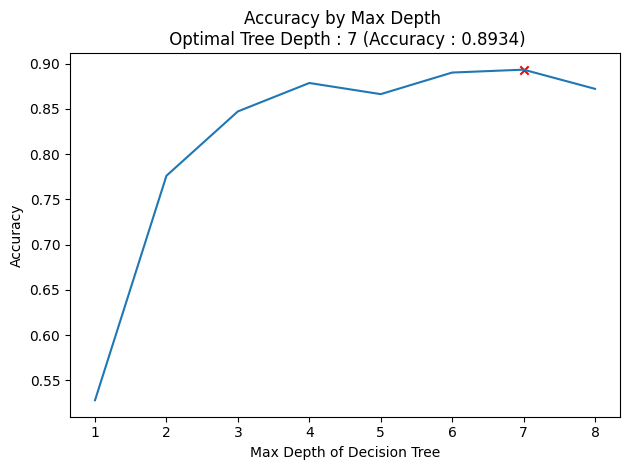

In [68]:
# Visualise max_depth
max_accuracy = max(accuracy_scores)
max_accuracy_index = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_index]

plt.plot(max_depth_list,accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker='x',color='red')
plt.title(f'Accuracy by Max Depth \n Optimal Tree Depth : {optimal_depth} (Accuracy : {round(max_accuracy,4)})')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()


Analysis shows that we get a pretty close to ideal model from a depth of 4. 

While we will be losing a bit of accuracy, limiting the depth to 4 will reduce the possibility of the model failing to predict new data

In [69]:
# feature selection with regressive feature elemination
tree2 = DecisionTreeRegressor(max_depth=4)

In [70]:
# fit model
tree2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [71]:
# Assess accuracy and R2
y_pred = tree2.predict(X_test) # Create predictions for tests
r_squared = r2_score(y_test,y_pred) # Compare prediction results to actual result
r_squared

0.8786690493044959

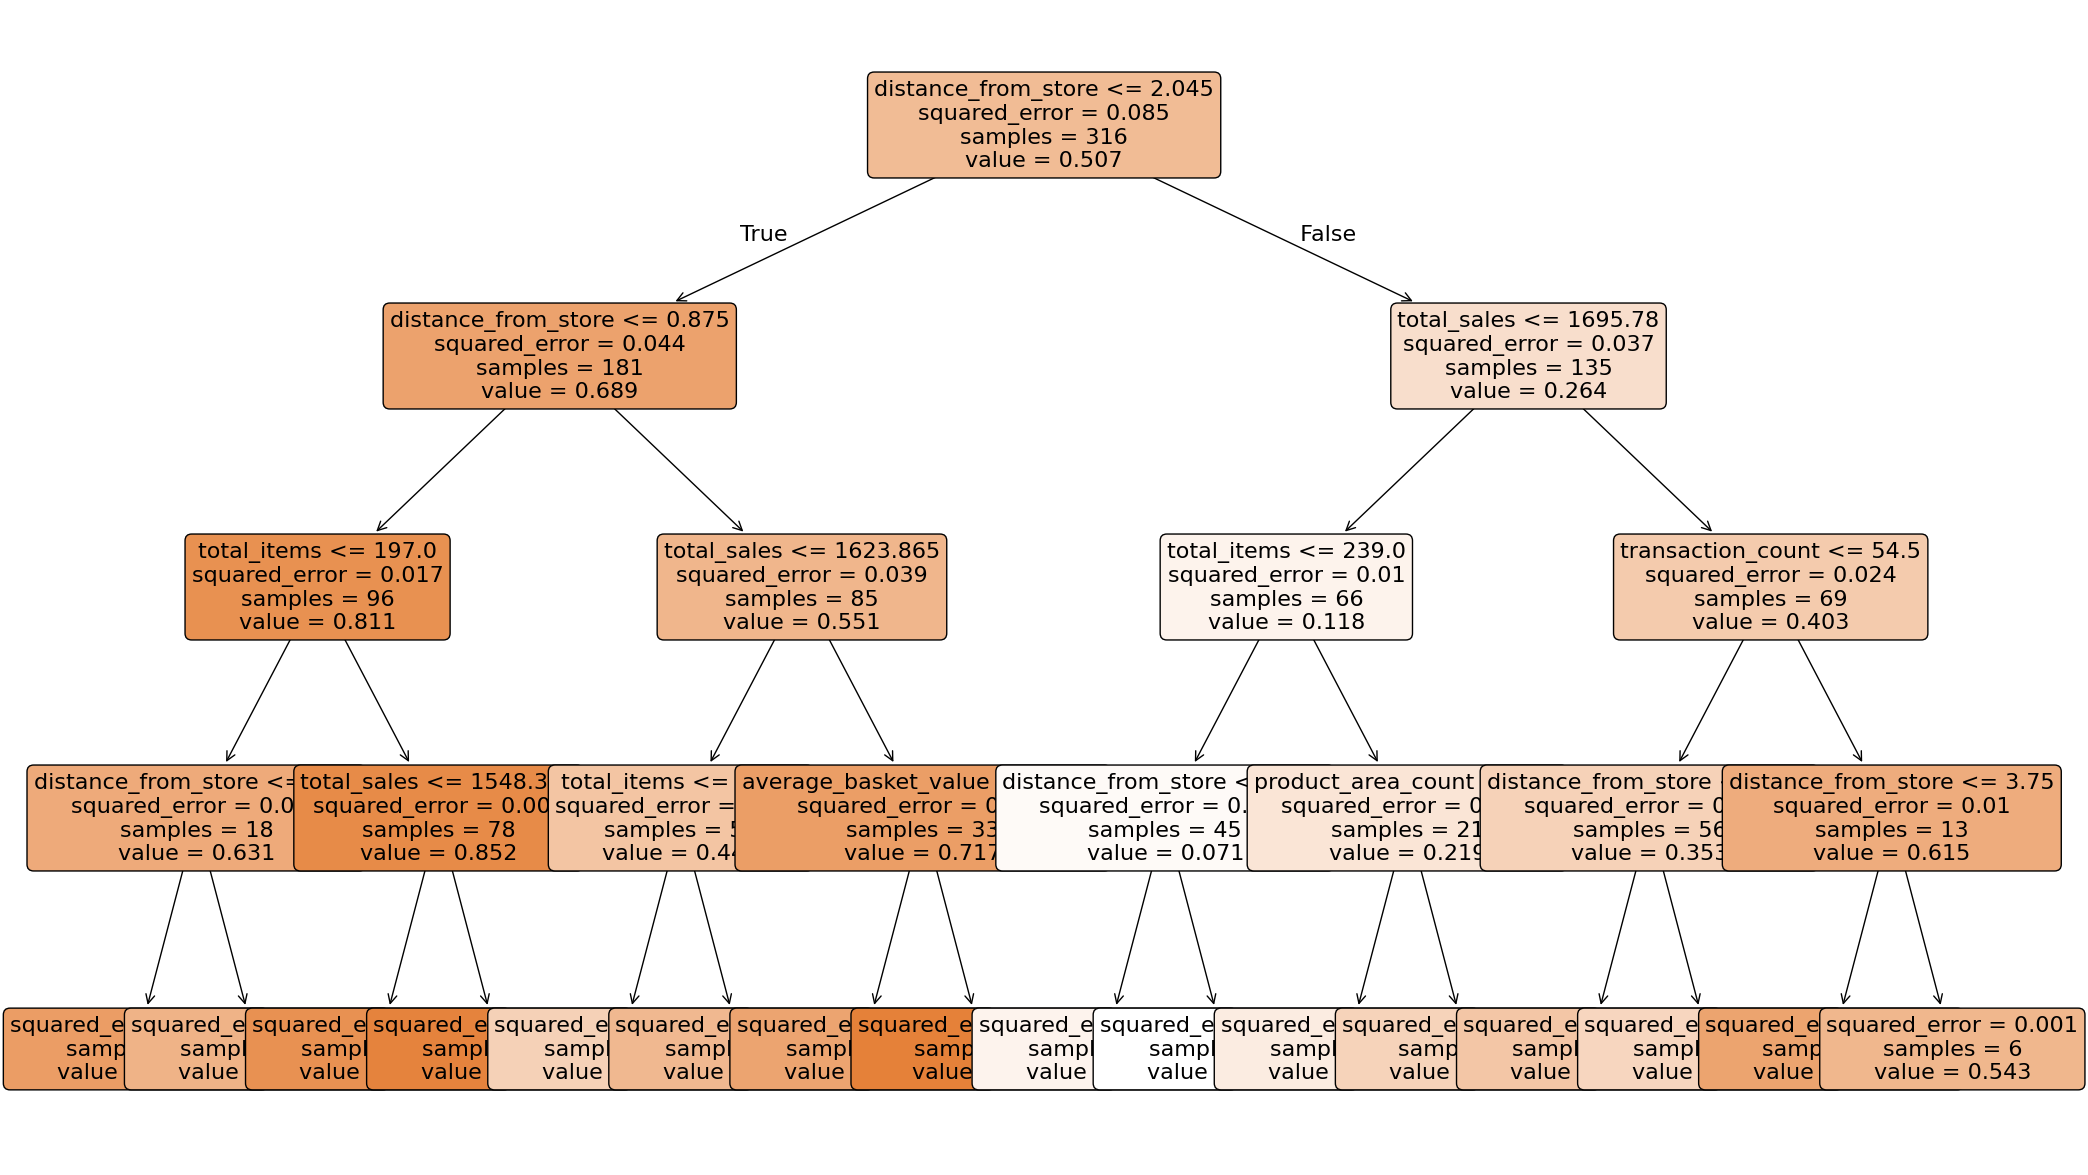

In [72]:
# Plot Model
plt.figure(figsize=(25,15))
tree_plot = plot_tree(tree2,
                      feature_names=X.columns,
                      filled=True,
                      rounded=True,
                      fontsize=16
)